In [378]:

import importlib
import experiment
importlib.reload(experiment)
import models
importlib.reload(models)

from experiment import *

In [379]:
exp_name = "GST-D1-HLM_E3-FL"

from pathlib import Path
path = Path("./data/GST-D1-HLM_E3-FL_230105/redoGST-DCP1-HLM_VS_EDC3-FL")
fs = sorted(list(path.glob("*.csv")))

controls_path = Path("./data/GST-D1-HLM_E3-FL_230105/refs")
controls_fs = sorted(list(controls_path.glob("*.csv")))
print(len(fs))
print(len(controls_fs))

20
5


In [380]:
exp = Exp()
exp.load_bli_data(fs)
# exp.plot()


In [381]:
controls = Exp()
controls.load_bli_data(controls_fs)
controls.interstep_correction()
# controls.plot()


In [382]:
#load descriptions, need to copy from blitz
desc = Path(f"./data/GST-D1-HLM_E3-FL_230105/dataset_description.txt")
df = pd.read_csv(desc, sep='\t', index_col=0)
# df

In [383]:
#assign concentrations from desc to each dataset
concs = df['Conc. (uM)'].to_dict()
analyze = df['Analyze'].to_dict()

for ds in exp.datasets:
    idx = ds.name[:-4].split('_')[-1]
    idx=int(idx)
    c = concs[idx]
    if np.isnan(c): c=0
    ds.steps[0].concentration = c*1e-6
    ds.use_for_fit = analyze[idx]



In [384]:
for ds in exp.datasets:
    print(ds)
exp.interstep_correction()
# exp.plot()

Dataset(0, name = 2023-01-05_001.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(1, name = 2023-01-05_002.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(2, name = 2023-01-05_003.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(3, name = 2023-01-05_004.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(4, name = 2023-01-05_005.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(5, name = 2023-01-05_006.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(6, name = 2023-01-05_007.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 1)
Dataset(7, name = 2023-01-05_008.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(8, name = 2023-01-05_009.csv, no_steps = 2, len = 739.8, baseline = (230.0, 260.0), use_for_fit = 0)
Dataset(9, name = 2

In [385]:
#assign conentrations to controls
controls_c = [0.,0.2,0.4,0.8,1.6]
controls_c = [c*1e-6 for c in controls_c]

for ds, c in zip(controls, controls_c):
    ds.steps[0].concentration = c




In [386]:
controls_dict = {}
for ds in controls:
    control_mask = ds.t>=ds.steps[0].start
    c = ds.steps[0].concentration
    controls_dict[c] = ds.response[control_mask]

#subtract controls from ds
for ds in exp:
    if not ds.use_for_fit: continue
    print(ds.steps[0].concentration)
    start = ds.steps[0].start
    mask = ds.t>=start
    r = ds.response[mask]
    c = ds.steps[0].concentration
    if c in controls_dict:
        print('correcting c=',c)
        ds.response[mask] = np.subtract(r, controls_dict[c])
        

# exp.plot()

1.6e-06
correcting c= 1.6e-06
1.6e-06
correcting c= 1.6e-06
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07
8e-07
correcting c= 8e-07
2e-07
correcting c= 2e-07
2e-07
correcting c= 2e-07
1e-07
1e-07
8e-07
correcting c= 8e-07
4e-07
correcting c= 4e-07


In [387]:
exp.crop(3)

Exp.params is None. Fit and offset plots are not available


(<Figure size 640x480 with 1 Axes>, <Axes: >)

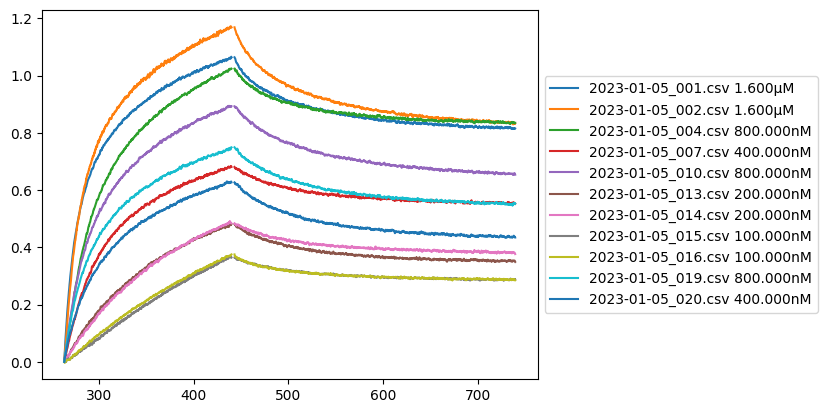

In [388]:
exp.interstep_correction()
exp.plot()

In [389]:
#remove some datasets
ds_to_remove = []#[15, 12, 19, 18, 0, 3]
for ds in exp:
    if ds.use_for_fit == False:
        ds_to_remove.append(ds)
for ds in ds_to_remove:
    exp.datasets.remove(ds)

In [390]:
exp.model = models.Bivalent_analyte()
exp.model.params_definitions

{'ka1': <Parameter 'ka1', value=10000.0, bounds=[10.0:100000000.0]>,
 'kd1': <Parameter 'kd1', value=0.01, bounds=[1e-06:0.1]>,
 'ka2': <Parameter 'ka2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kd2': <Parameter 'kd2', value=0.01, bounds=[1e-07:10000000.0]>,
 'kt': <Parameter 'kt', value=10000000.0, bounds=[10.0:1000000000000.0]>,
 'ymax': <Parameter 'ymax', value=1, bounds=[0:1000]>,
 'offset': <Parameter 'offset', value=0, bounds=[-1000:1000]>}

In [391]:
exp.model.params_definitions['ymax'].user_data['type']='global'

# exp.model.params_definitions['ymax1'].user_data['type']='global'
# exp.model.params_definitions['ymax2'].user_data['type']='global'

exp.create_params(offsets=1, mtl = 0)
exp.params


name,value,initial value,min,max,vary
ka1,10000.0000,10000.0,10.0000000,1.0000e+08,True
kd1,0.01000000,0.01,1.0000e-06,0.10000000,True
ka2,0.01000000,0.01,1.0000e-07,10000000.0,True
kd2,0.01000000,0.01,1.0000e-07,10000000.0,True
ymax,1.00000000,1,0.00000000,1000.00000,True
offset_ds0_step0,0.00000000,0,-1000.00000,1000.00000,True
offset_ds0_step1,0.00000000,0,-1000.00000,1000.00000,True
offset_ds1_step0,0.00000000,0,-1000.00000,1000.00000,True
offset_ds1_step1,0.00000000,0,-1000.00000,1000.00000,True
offset_ds3_step0,0.00000000,0,-1000.00000,1000.00000,True


In [392]:
exp.fit_params()

Nan and inf are not valid responses. Some values in dataset 0 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 1 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 3 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 6 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 9 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 12 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 13 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 14 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 15 are not finite. LMFIT is set to omit.
Nan and inf are not valid responses. Some values in dataset 18 are not finite. LMFIT is set to o

'`ftol` termination condition is satisfied.'

(<Figure size 640x480 with 1 Axes>, <Axes: >)

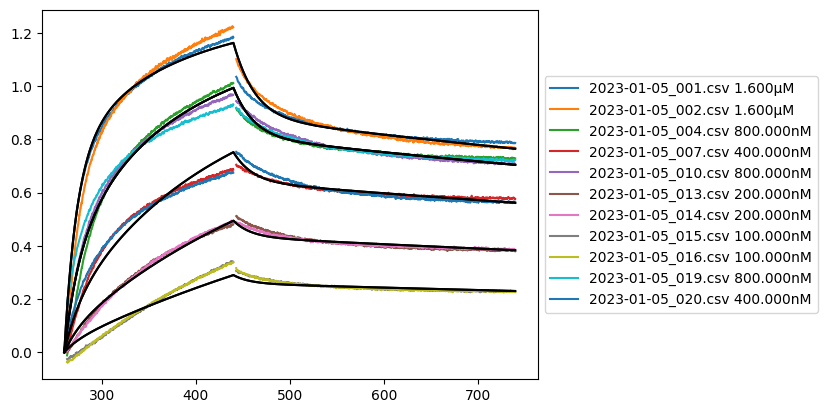

In [393]:
flag = False
for par in exp.params:
    if "offset" in par:
        flag=True

exp.plot(fit=True, correct_offsets=flag)

In [394]:
exp.result

In [395]:
import plotly.graph_objects as go

fig = go.Figure()

for ds in exp.datasets:
    if ds.use_for_fit == False: continue
    x = np.array([])
    y = np.array([])
    y_fit = np.array([])
    
    for step in ds.steps:
        # if step.concentration>0: color = 'orangered'
        # elif step.concentration==0: color = 'cornflowerBlue'
        # else: color = 'lightgrey'
        mask = (ds.t>=step.start) & (ds.t<step.stop)

        if f"offset_ds{ds.index}_step{step.index}" in exp.params:
                offset = exp.params[f'offset_ds{ds.index}_step{step.index}'].value
        else: 
            offset = 0
        
        x_step = ds.t[mask]
        y_step = ds.response[mask] - offset
        y_fit_step = ds.fit_response[mask] - offset

        x = np.concatenate([x, x_step])
        y = np.concatenate([y, y_step])
        y_fit = np.concatenate([y_fit, y_fit_step])

    
    x = x - x[0]
    fig.add_scatter(x = x, 
                    y = y_fit,
                    marker=dict(size=0, 
                            color='black',
                            line=dict(width=1, color='black')),
                    line=dict(
                         width=2, 
                         color='black'
                         ),
                    name=ds.steps[0].concentration,)

        

    fig.add_scatter(x = x,
                    y = y,
                    marker=dict(
                            size=0, 
                            #color=color, 
                            line=dict(
                                    width=0.1, 
                                    #color=color
                                    )),
                    line=dict(
                            width=1, 
                            #color=color
                            ),
                    name=f"{ds.index}_{ds.steps[0].concentration}",
                    )



fig.update_layout(
            height=600,
            width = 800,
            font_family="Arial",
            font_size = 24,
            showlegend=False,
            margin=dict(l=0,r=0,b=0,t=0,pad=0), 
            template='plotly_white',
            paper_bgcolor="rgb(255, 255, 255)",  
            plot_bgcolor="rgb(255, 255, 255)") 

fig.update_xaxes(
    ticklabelposition="inside top", 
    title='time [s]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)

fig.update_yaxes(
    ticklabelposition="outside top", 
    title='Response [nm]',
    showline=True, 
    linewidth=1, 
    linecolor='black', 
    showgrid=False,
    mirror=True)



fig.show()

In [360]:
for ds in exp:
    if ds.index in [15, 12, 19, 18, 0, 3]:
        ds.use_for_fit = False
    if ds.index in [6]:
        ds.use_for_fit = True
    # if ds.steps[0].concentration==16e-6:
    #     ds.use_for_fit = True
[ds.index for ds in exp]



[0, 1, 3, 6, 9, 12, 13, 14, 15, 18, 19]

In [25]:
exp.crop(3)

In [302]:
exp.model.name

'Heterogeneous ligand'

In [299]:
import kaleido
exp_name = "GST-D1_E3-HLM"
fig.write_image(f'{exp_name}-{exp.model.name}.png')

In [300]:
report_filename = 'gst-d1-hlm_e3-lsm'

from lmfit.printfuncs import fitreport_html_table
s = fitreport_html_table(exp.result, show_correl=True,  min_correl=0.1)

with open(f"{exp_name}-{exp.model.name}.htm", 'w') as f:
    f.write(s)


In [301]:
from uncertainties import ufloat
def get_html_report(show_correl=True):
    result = exp.result
    tables = result._repr_html_(show_correl=show_correl)
    
    if ('ka' in result.params) and ('kd' in result.params):
        t = []
        cell = lambda x, tag: f'<{tag}> {x} </{tag}>'
        
        has_er = hasattr(result.params['ka'], 'stderr') and (result.params['ka'].stderr is not None)

        if has_er:
            ka = ufloat(float(result.params['ka'].value), float(result.params['ka'].stderr))
            kd = ufloat(float(result.params['kd'].value), float(result.params['kd'].stderr))
            Kd = kd/ka
        else:
            Kd = result.params['kd'].value/result.params['ka'].value

        t.append('<h2>Dissociation constant</h2>')
        t.append('<table><tr>')
        t.append(cell(f"<b>Name</b>", 'td'))
        t.append(cell(f"<b>value</b>", 'td'))
        t.append(cell(f"<b>standard error</b>", 'td'))
        t.append(cell(f"<b>relative error</b>", 'td'))  
        t.append('</tr><tr>')
        t.append(cell(f"<b>Kd</b>", 'td'))
        if has_er:
            t.append(cell(f"{Kd.n:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev:.5e}", 'td'))
            t.append(cell(f"{Kd.std_dev/Kd.n:.2%}", 'td'))
        else:
            t.append(cell(f"{Kd:.5e}", 'td'))
            t.append(cell("NA", 'td'))
            t.append(cell("NA", 'td'))
        t.append('</table></tr></table>')

        return tables + ''.join(t)
    
    else: 
        return tables

report = get_html_report(show_correl=False)
with open(f'{exp_name}-{exp.model.name}-extended_report.htm','w') as f:
    f.write(report)

In [124]:
from uncertainties import ufloat

In [125]:
# pars = exp.result.params

# ka1 = pars['ka1'].value
# ka1_er = ka1*25.05/100
# kd1 = pars['kd1'].value
# ka2 = pars['ka2'].value
# kd2 = pars['kd2'].value

# Kd = (kd1 * kd2) / (ka1 * ka2)

In [358]:
exp.result.params

name,value,standard error,relative error,initial value,min,max,vary
ka1,12985.5994,1396.57786,(10.75%),10000.0,10.0000000,1.0000e+08,True
kd1,0.03432055,0.00809383,(23.58%),0.01,1.0000e-06,0.10000000,True
ka2,0.01974791,0.00375394,(19.01%),0.01,1.0000e-07,10000000.0,True
kd2,3.3477e-04,6.3191e-05,(18.88%),0.01,1.0000e-07,10000000.0,True
ymax,1.48838347,0.10966651,(7.37%),1,0.00000000,1000.00000,True
offset_ds0_step0,-0.12097802,0.04882031,(40.35%),0,-1000.00000,1000.00000,True
offset_ds0_step1,0.02824894,0.03424010,(121.21%),0,-1000.00000,1000.00000,True
offset_ds1_step0,-0.05335721,0.04882031,(91.50%),0,-1000.00000,1000.00000,True
offset_ds1_step1,0.06636789,0.03424010,(51.59%),0,-1000.00000,1000.00000,True
offset_ds3_step0,0.01198533,0.03626291,(302.56%),0,-1000.00000,1000.00000,True


In [359]:
exp.result